In [1345]:
import numpy as np
import pytreenet as ptn
from copy import deepcopy
# np.random.seed(82)

In [1346]:
d = 2

In [1347]:
from qutip import coherent
def product_state(ttn, bond_dim=2 , physical_dim= 2):
    product_state = deepcopy(ttn)
    #A = np.asarray(d*[1/np.sqrt(physical_dim)])
    #A = np.array([0,1j* 1/np.sqrt(2),1j * 1/np.sqrt(2)])
    # A = np.array([0,1])
    alpha = 2
    A = np.array(coherent(physical_dim , alpha).full())
    for node_id in product_state.nodes.keys():
        n = product_state.tensors[node_id].ndim - 1
        tensor = A.reshape((1,) * n + (physical_dim,))
        T = np.pad(tensor, n*((0, bond_dim-1),) + ((0, 0),))
        product_state.tensors[node_id] = T
        product_state.nodes[node_id].link_tensor(T)  
    return product_state

In [1348]:
shapes = {
    (0, 0): (2, 2, 2, d),
    (0, 1): (2, 2, d),
    (0, 2): (2, 2, d),
    (1, 0): (2, 2, d),
    (1, 1): (2, d),
    (1, 2): (2, d),
    (2, 0): (2, 2, d),
    (2, 1): (2, 2, 2, d),
    (2, 2): (2, d)
}


sites = {
    (i, j): ptn.random_tensor_node(shapes[(i, j)], identifier=f"Site({i},{j})") for i in range(3) for j in range(3)
}

ttn = ptn.TreeTensorNetworkState()

ttn.add_root(sites[(0, 0)][0], sites[(0, 0)][1])

connections = [
    ((0, 0), (0, 1), 0, 0),
    ((0, 1), (0, 2), 1, 0),
    ((0, 2), (1, 2), 1, 0),
    ((0, 0), (1, 0), 1, 0),
    ((1, 0), (2, 0), 1, 0),
    ((2, 0), (2, 1), 1, 0),
    ((2, 1), (1, 1), 1, 0),
    ((2, 1), (2, 2), 2, 0)]


for (parent, child, parent_leg, child_leg) in connections:
    parent_id = f"Site({parent[0]},{parent[1]})"
    child_id = f"Site({child[0]},{child[1]})"
    ttn.add_child_to_parent(sites[child][0], sites[child][1], child_leg, parent_id, parent_leg)

# ttn = product_state(ttn , bond_dim= 2, physical_dim = d)

nodes = {
    (i, j): (ptn.Node(tensor=ttn.tensors[f"Site({i},{j})"].conj() , identifier=f"Node({i},{j})"), ttn.tensors[f"Site({i},{j})"].conj()) for i in range(3) for j in range(3)
}

ttn.add_child_to_parent(nodes[(0,0)][0], nodes[(0,0)][1], 2, "Site(0,0)", 2)

connections = [
    ((0, 0), (0, 1), 1, 0),
    ((0, 1), (0, 2), 1, 0),
    ((0, 2), (1, 2), 1, 0),
    ((0, 0), (1, 0), 2, 0),
    ((1, 0), (2, 0), 1, 0),
    ((2, 0), (2, 1), 1, 0),
    ((2, 1), (1, 1), 1, 0),
    ((2, 1), (2, 2), 2, 0),
]

for (parent, child, parent_leg, child_leg) in connections:
    parent_id = f"Node({parent[0]},{parent[1]})"
    child_id = f"Node({child[0]},{child[1]})"
    ttn.add_child_to_parent(nodes[child][0], nodes[child][1], child_leg, parent_id, parent_leg)

In [1349]:
shapes = {
    (0, 0): (2, 2, 2, d),
    (0, 1): (2, 2, d),
    (0, 2): (2, 2, d),
    (1, 0): (2, 2, d),
    (1, 1): (2, d),
    (1, 2): (2, d),
    (2, 0): (2, 2, d),
    (2, 1): (2, 2, 2, d),
    (2, 2): (2, d)
}


sites = {
    (i, j): ptn.random_tensor_node(shapes[(i, j)], identifier=f"Site({i},{j})") for i in range(3) for j in range(3)
}

ttn = ptn.TreeTensorNetworkState()

ttn.add_root(sites[(0, 0)][0], sites[(0, 0)][1])

connections = [
    ((0, 0), (0, 1), 0, 0),
    ((0, 1), (0, 2), 1, 0),
    ((0, 2), (1, 2), 1, 0),
    ((0, 0), (1, 0), 1, 0),
    ((1, 0), (2, 0), 1, 0),
    ((2, 0), (2, 1), 1, 0),
    ((2, 1), (1, 1), 1, 0),
    ((2, 1), (2, 2), 2, 0)]


for (parent, child, parent_leg, child_leg) in connections:
    parent_id = f"Site({parent[0]},{parent[1]})"
    child_id = f"Site({child[0]},{child[1]})"
    ttn.add_child_to_parent(sites[child][0], sites[child][1], child_leg, parent_id, parent_leg)

ttn = product_state(ttn , bond_dim= 4, physical_dim = d)

nodes = {
    (i, j): (ptn.Node(tensor=ttn.tensors[f"Site({i},{j})"].conj() , identifier=f"Node({i},{j})"), ttn.tensors[f"Site({i},{j})"].conj()) for i in range(3) for j in range(3)
}

ttn.add_child_to_parent(nodes[(0,0)][0], nodes[(0,0)][1], 2, "Site(0,0)", 2)

connections = [
    ((0, 0), (0, 1), 1, 0),
    ((0, 1), (0, 2), 1, 0),
    ((0, 2), (1, 2), 1, 0),
    ((0, 0), (1, 0), 2, 0),
    ((1, 0), (2, 0), 1, 0),
    ((2, 0), (2, 1), 1, 0),
    ((2, 1), (1, 1), 1, 0),
    ((2, 1), (2, 2), 2, 0),
]

for (parent, child, parent_leg, child_leg) in connections:
    parent_id = f"Node({parent[0]},{parent[1]})"
    child_id = f"Node({child[0]},{child[1]})"
    ttn.add_child_to_parent(nodes[child][0], nodes[child][1], child_leg, parent_id, parent_leg)

In [1350]:
I = ptn.TTNO.Identity(ttn)
ptn.adjust_bra_to_ket(ttn)

for ket_id in [node.identifier for node in ttn.nodes.values() if str(node.identifier).startswith("S")]:
    bra_id = ket_id.replace('Site', 'Node')
    print(np.array_equal(ttn.tensors[ket_id].conj(), ttn.tensors[bra_id]))

ttn = ptn.normalize_ttn_Lindblad_3_conj(ttn , "Site(0,0)", "Node(0,0)")

for ket_id in [node.identifier for node in ttn.nodes.values() if str(node.identifier).startswith("S")]:
    bra_id = ket_id.replace('Site', 'Node')
    print(np.array_equal(ttn.tensors[ket_id].conj(), ttn.tensors[bra_id]))

ttn.operator_expectation_value_Lindblad(I)


True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


array(1.+0.j)

In [1351]:
def get_neighbors_Site(x, y, Lx, Ly):
  neighbors = []
  
  # Right neighbor
  if x < Lx - 1:
      neighbors.append(f"Site({x+1},{y})")
  
  # Up neighbor
  if y < Ly - 1:
      neighbors.append(f"Site({x},{y+1})")
  
  return neighbors

def get_neighbors_Node(x, y, Lx, Ly):
  neighbors = []

  # Right neighbor
  if x < Lx - 1:
      neighbors.append(f"Node({x+1},{y})")
  
  # Up neighbor
  if y < Ly - 1:
      neighbors.append(f"Node({x},{y+1})")
  
  return neighbors

In [1352]:
def Liouville(t, U, gamma, m, L, Lx, Ly, d):
    creation_op, annihilation_op, number_op = ptn.bosonic_operators(d)
    
    conversion_dict = {
        "b^dagger": creation_op,
        "b": annihilation_op,
        f"I{d}": np.eye(d)
    }
    
    conversion_dict.update({
        "it * b^dagger": t*1j * creation_op,
        "it * b": t*1j * annihilation_op,
        "-iU * n * (n - 1)": -U*1j * number_op @ (number_op - np.eye(d)),
        "im*n": m*1j*number_op
    })
    
    terms = []
    
    # Hopping terms
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Site({x},{y})"
            neighbors = get_neighbors_Site(x, y, Lx, Ly)            
            for neighbor in neighbors:
                terms.append(ptn.TensorProduct({current_site: "it * b^dagger", neighbor: "b"}))
                terms.append(ptn.TensorProduct({current_site: "it * b", neighbor: "b^dagger"}))
                

    
    # On-site interaction terms
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Site({x},{y})"
            terms.append(ptn.TensorProduct({current_site: "-iU * n * (n - 1)"}))

    # Chemical potential terms
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Site({x},{y})"
            terms.append(ptn.TensorProduct({current_site: "im*n"}))        
    
    H1 = ptn.Hamiltonian(terms, conversion_dict)
    
    conversion_dict = {
        "b^dagger.T": creation_op.T,
        "b.T": annihilation_op.T,
        f"I{d}": np.eye(d)
    }
    
    conversion_dict.update({
        "-it * b^dagger.T": -t*1j * creation_op.T,
        "-it * b.T": -t*1j * annihilation_op.T,
        "iU * n * (n - 1).T": (U*1j * number_op @ (number_op - np.eye(d))).T,
        "-im*n.T": -m*1j* number_op.T
    })
    
    terms = []
    
    # Hopping terms
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Node({x},{y})"
            neighbors = get_neighbors_Node(x, y, Lx, Ly)
            for neighbor in neighbors:
                terms.append(ptn.TensorProduct({current_site: "-it * b^dagger.T", neighbor: "b.T"}))
                terms.append(ptn.TensorProduct({current_site: "-it * b.T", neighbor: "b^dagger.T"}))

    # On-site interaction terms
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Node({x},{y})"
            terms.append(ptn.TensorProduct({current_site: "iU * n * (n - 1).T"}))    

    # Chemical potential terms
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Node({x},{y})"
            terms.append(ptn.TensorProduct({current_site: "-im*n.T"}))
            
    H2 = ptn.Hamiltonian(terms, conversion_dict)
    H1.__add__(H2)

    
    L = np.sqrt(gamma) * L
    
    conversion_dict = {    
    "L": L,
    "L^dagger.T": L.conj().T,
    "-1/2 (L^dagger @ L) " : -1/2 * L.conj().T @ L,
    "-1/2 (L^dagger @ L).T": -1/2 * (L.conj().T @ L).T}
    
    terms = []
    for x in range(Lx):
        for y in range(Ly):
            out_site = f"Node({x},{y})"
            in_site = f"Site({x},{y})"
            terms.append(ptn.TensorProduct({in_site: "L" , out_site: "L^dagger.T"}))
            terms.append(ptn.TensorProduct({in_site: "-1/2 (L^dagger @ L) "}))
            terms.append(ptn.TensorProduct({out_site: "-1/2 (L^dagger @ L).T"}))

    H3 = ptn.Hamiltonian(terms, conversion_dict)
    H1.__add__(H3)
    return H1

In [1353]:
def Unitary(t, U, m, Lx, Ly, d):
    creation_op, annihilation_op, number_op = ptn.bosonic_operators(d)
    
    conversion_dict = {
        "b^dagger": creation_op,
        "b": annihilation_op,
        f"I{d}": np.eye(d)
    }
    
    conversion_dict.update({
        "it * b^dagger": t * 1.0j* creation_op,
        "it * b": t* 1.0j * annihilation_op,
        "-iU * n * (n - 1)": -U* 1.0j * number_op @ (number_op - np.eye(d)),
        "im*n": m *1j* number_op

    })
    
    terms = []
    
    # Hopping terms
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Site({x},{y})"
            
            neighbors = get_neighbors_Site(x, y, Lx, Ly)
            
            for neighbor in neighbors:
                terms.append(ptn.TensorProduct({current_site: "it * b^dagger", neighbor: "b"}))
                terms.append(ptn.TensorProduct({current_site: "it * b", neighbor: "b^dagger"}))
    
    # On-site interaction terms
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Site({x},{y})"
            terms.append(ptn.TensorProduct({current_site: "-iU * n * (n - 1)"}))
    
    # Chemical potential terms
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Site({x},{y})"
            terms.append(ptn.TensorProduct({current_site: "im*n"}))

    H1 = ptn.Hamiltonian(terms, conversion_dict)
    
    conversion_dict = {
        "b^dagger.T": creation_op.T,
        "b.T": annihilation_op.T,
        f"I{d}": np.eye(d)
    }
    
    conversion_dict.update({
        "-it * b^dagger.T": -t* 1.0j * creation_op.T,
        "-it * b.T": -t* 1.0j * annihilation_op.T,
        "iU * n * (n - 1).T": (U* 1.0j* number_op @ (number_op - np.eye(d))).T,
        "-im*n.T": -m *1j* number_op.T
    })
    
    terms = []
    
    # Hopping terms
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Node({x},{y})"
            neighbors = get_neighbors_Node(x, y, Lx, Ly)
            for neighbor in neighbors:
                terms.append(ptn.TensorProduct({current_site: "-it * b^dagger.T", neighbor: "b.T"}))
                terms.append(ptn.TensorProduct({current_site: "-it * b.T", neighbor: "b^dagger.T"}))
    
    # On-site interaction terms
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Node({x},{y})"
            terms.append(ptn.TensorProduct({current_site: "iU * n * (n - 1).T"}))   

    # Chemical potential terms
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Node({x},{y})"
            terms.append(ptn.TensorProduct({current_site: "-im*n.T"}))         

    H2 = ptn.Hamiltonian(terms, conversion_dict)
    H1.__add__(H2)
    return H1

In [1354]:
def BoseHubbard_ham(t, U, m, Lx, Ly, d):
    creation_op, annihilation_op, number_op = ptn.bosonic_operators(d)
    
    conversion_dict = {
        "b^dagger": creation_op,
        "b": annihilation_op,
        f"I{d}": np.eye(d)}
    
    conversion_dict.update({
        "-t * b^dagger": -t * creation_op,
        "-t * b": -t * annihilation_op,
        "U * n * (n - 1)": U * number_op @ (number_op - np.eye(d)),
        "-m*n": -m * number_op
    })
    
    terms = []
    
    # Hopping terms
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Site({x},{y})"
            neighbors = get_neighbors_Site(x, y, Lx, Ly)
            for neighbor in neighbors:
                terms.append(ptn.TensorProduct({current_site: "-t * b^dagger", neighbor: "b"}))
                terms.append(ptn.TensorProduct({current_site: "-t * b", neighbor: "b^dagger"}))


    # On-site interaction terms
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Site({x},{y})"
            terms.append(ptn.TensorProduct({current_site: "U * n * (n - 1)"}))
    
    # Chemical potential terms
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Site({x},{y})"
            terms.append(ptn.TensorProduct({current_site: "-m*n"}))

    return ptn.Hamiltonian(terms, conversion_dict)


In [1355]:
def Number_op_total(Lx, Ly, dim=2):
    creation_op, annihilation_op, number_op = ptn.bosonic_operators(dim)
    conversion_dict = {"n": number_op , f"I{dim}": np.eye(dim)}

    terms = []
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Site({x},{y})"
            terms.append(ptn.TensorProduct({current_site: "n"}))

    return ptn.Hamiltonian(terms, conversion_dict)     

def Number_op_local( node_id , dim=2):
    creation_op, annihilation_op, number_op = ptn.bosonic_operators(dim)
    conversion_dict = {"n": number_op , f"I{dim}": np.eye(dim)}

    terms = []
    terms.append(ptn.TensorProduct({node_id: "n"}))

    return ptn.Hamiltonian(terms, conversion_dict)

def Correlation_function(node_id1, node_id2, dim=2):
    creation_op, annihilation_op, number_op = ptn.bosonic_operators(dim)
    conversion_dict = {
        "b^dagger": creation_op,
        "b": annihilation_op,
        f"I{dim}": np.eye(dim)
    }
    
    terms = []
    terms.append(ptn.TensorProduct({node_id1: "b^dagger", node_id2: "b"}))
    return ptn.Hamiltonian(terms, conversion_dict)

In [1356]:
def exchange_bra_ket_tensors(ttn):
    state = deepcopy(ttn)
    ptn.adjust_bra_to_ket(state)
    for ket_id in list(state.nodes.keys())[:(len(state.nodes.keys())//2)]:
        i, j = ket_id.replace('Site(', '').replace(')', '').split(',')
        bra_id = f"Node({i},{j})"
        T1 = state.tensors[bra_id]
        T2 = state.tensors[ket_id]
        state.tensors[ket_id] = T1
        state.nodes[ket_id].link_tensor(T1)
        state.tensors[bra_id] = T2
        state.nodes[bra_id].link_tensor(T2)
    return state

def substitute_out_or_in_legs_of_ttn_with_identity(state, out_or_in , bond_dim=2):
    ttn = deepcopy(state)
    if out_or_in == "Out":
       for node_id in list(ttn.nodes.keys())[(len(ttn.nodes.keys())//2):]:
        n = ttn.tensors[node_id].ndim - 1
        T = np.reshape(np.array([[1,0]]), (n*(1,) + (2,)))
        T = np.pad(T, n*((0, bond_dim-1),) + ((0, 0),))
        ttn.tensors[node_id] = T
        ttn.nodes[node_id].link_tensor(T)   
    if out_or_in == "In":
        for node_id in list(ttn.nodes.keys())[:len(ttn.nodes.keys())//2]:
            n = ttn.tensors[node_id].ndim
            T = ttn.tensors[node_id]
            T = np.reshape(np.array([[1,0]]), (n*(1,) + (2,)))
            T = np.pad(T, n*((0, bond_dim-1),) + ((0, 0),))
            ttn.tensors[node_id] = T
            ttn.nodes[node_id].link_tensor(T)        
    return ttn


In [1357]:
t = 0.4
U = 0.8
m = 0.4

# TTNO : Hamiltonian acting on in_legs
H1 = BoseHubbard_ham(t, U, m, 3, 3, d)
H1 = H1.pad_with_identities(ttn, symbolic= True)
H = ptn.TTNO.from_hamiltonian(H1, ttn)

# TTNO : Liouville operator 
creation_op, annihilation_op, number_op = ptn.bosonic_operators(d)
L = annihilation_op 
J = 0.16
H1 = Liouville(t, U, J, m ,L, 3, 3, d)
H1 = H1.pad_with_identities(ttn , symbolic= True)
L_fancy = ptn.TTNO.from_hamiltonian(H1, ttn)

# TTNO : Unitary operator
H1 = Unitary(t, U, m, 3, 3, d)
H1 = H1.pad_with_identities(ttn, symbolic= True)
U = ptn.TTNO.from_hamiltonian(H1, ttn)

I = ptn.TTNO.Identity(ttn)

N = Number_op_total(3, 3, d)
N = N.pad_with_identities(ttn, symbolic= True)
N = ptn.TTNO.from_hamiltonian(N, ttn)

n_site_dict = {}
for node in list(ttn.nodes.values())[:(len(ttn.nodes.keys())//2)]:
    node_id = node.identifier
    n_site = Number_op_local(node_id, d)
    n_site = n_site.pad_with_identities(ttn, symbolic=True)
    n_site = ptn.TTNO.from_hamiltonian(n_site, ttn)
    n_site_dict[f'n_{node_id}'] = n_site
n_site_list = list(n_site_dict.values())

# Correlation function
node_id1 = "Site(0,0)"
node_id2 = "Site(2,2)"
H1 = Correlation_function(node_id1, node_id2, d)
H1 = H1.pad_with_identities(ttn, symbolic= True)
Corr = ptn.TTNO.from_hamiltonian(H1, ttn)

print(ttn.operator_expectation_value_Lindblad(I))
print(ttn.operator_expectation_value_Lindblad(N) / ttn.operator_expectation_value_Lindblad(I))
print(ttn.operator_expectation_value_Lindblad(H) / ttn.operator_expectation_value_Lindblad(I))
print(np.linalg.norm(ttn.operator_expectation_value_Lindblad(Corr)))


(1+0j)
(7.441396293886255+0j)
(-4.351158558124837+0j)
0.14318750422607668


In [1358]:
# Config : Lindblad = True
# time_evolve with exponent = hamiltonian * time_difference
# evaluate_operator with operator_expectation_value_Lindblad(operator)
# normalize_ttn_Lindblad after each run_one_time_step_ex

tdvp_ex1 = ptn.SecondOrderOneSiteTDVP(initial_state = ttn,
                                     hamiltonian = L_fancy,
                                     time_step_size = 0.01,
                                     final_time = 4,
                                     operators = N,
                                     num_vecs = 3,
                                     tau = 1e-3,
                                     SVDParameters = ptn.SVDParameters(max_bond_dim = np.inf , rel_tol= -np.inf , total_tol = -np.inf),
                                     expansion_steps = 5000,
                                     t3n_dict= {'Site(0,0)': 'Site(1,0)',
                                                'Site(2,1)': 'Site(1,1)',
                                                'Node(0,0)': 'Node(1,0)',
                                                'Node(2,1)': 'Node(1,1)'},

                                     Lanczos_threshold = np.inf,
                                     k_fraction = 0.2, 
                                     validity_fraction = 1, 
                                     increase_fraction = 0.3,
                                     max_iter = 1, 

                                     initial_tol= 1e-20,
                                     tol_step= 50,
                                     rel_tot_bond = 30,
                                     max_bond= 220,
                                     norm_tol = 0,
                                     KrylovBasisMode = ptn.KrylovBasisMode.apply_1st_order_expansion,
                                     config = ptn.TTNTimeEvolutionConfig(record_bond_dim=True,
                                                                         Lindblad = True,
                                                                         T3NS= False) )

In [1359]:
v

NameError: name 'v' is not defined

In [ ]:
tdvp_ex1.run_ex(evaluation_time=2)


In [1202]:
from qutip import *
import numpy as np

# Define parameters
t = 0.4  # Hopping strength
U = 0.8  # On-site interaction strength
m = 0.4  # Chemical potential
gamma_relax = 0.16  # Relaxation rate

# Reduced lattice dimensions
Nx = 3  # Number of sites along x-direction
Ny = 3  # Number of sites along y-direction
N = Nx * Ny  # Total number of sites

# Reduced maximum number of bosons per site
nmax = 1

# Precompute the operators for each site
a_list = []
adag_list = []
n_list = []
si = qeye(nmax + 1)  # Identity operator for a single site
for n in range(N):
    op_list = [si] * N
    op_list[n] = destroy(nmax + 1)
    a_op = tensor(op_list)
    a_list.append(a_op)
    adag_list.append(a_op.dag())
    n_list.append(a_op.dag() * a_op)


# Function to map 2D lattice coordinates (i, j) to a site index
def site(i, j):
    return i + j * Nx

# Initialize the Hamiltonian
H = 0

# Build the Hamiltonian by summing over sites
for i in range(Nx):
    for j in range(Ny):
        n = site(i, j)
        H += 0.5 * U * n_list[n] * (n_list[n] - 1) - m * n_list[n]
        if i < Nx - 1:
            n_right = site(i + 1, j)
            H += -t * (adag_list[n] * a_list[n_right] + adag_list[n_right] * a_list[n])
        if j < Ny - 1:
            n_up = site(i, j + 1)
            H += -t * (adag_list[n] * a_list[n_up] + adag_list[n_up] * a_list[n])

# Initial state: product state of maximum occupation

#psi0 = tensor([basis(nmax + 1, nmax) for _ in range(N)]).unit()
# psi0 = tensor([(basis(nmax + 1, 0) + basis(nmax + 1, 1)).unit() for _ in range(N)])
alpha = 1
psi0 = tensor([coherent(nmax + 1, alpha) for _ in range(N)])
# Reduced simulation time and increased time step
total_time = 4  # Total time in seconds
time_step = 0.02  # Time step in seconds
tlist = np.arange(0, total_time + time_step, time_step)

# Define collapse operators (for the Lindblad equation)
custom_matrix = Qobj([[0, 1], [0, 0]])
jump_operator = []
si = qeye(nmax + 1) 
for n in range(N):
  op_list = [si] * N  # Create a list of identity operators
  op_list[n] = custom_matrix  # Replace the n-th site with the custom matrix
  custom_op = tensor(op_list)  # Create the tensor product
  jump_operator.append(custom_op)

c_ops = [np.sqrt(gamma_relax) * a for a in a_list]


# Observables to calculate - total particle number
N_total = sum(n_list)

# Solve the Schrödinger equation (more efficient for this case)
result = mesolve(H, psi0, tlist, c_ops, [N_total])

# Extract expectation values
total_number = result.expect[0]

# Print results
print("Time evolution of total particle number:")
for t, n in zip(tlist, total_number):
    print(f"Time: {t:.2f}, Total number: {n:.4f}")

Time evolution of total particle number:
Time: 0.00, Total number: 6.3727
Time: 0.02, Total number: 6.3523
Time: 0.04, Total number: 6.3320
Time: 0.06, Total number: 6.3118
Time: 0.08, Total number: 6.2916
Time: 0.10, Total number: 6.2715
Time: 0.12, Total number: 6.2515
Time: 0.14, Total number: 6.2315
Time: 0.16, Total number: 6.2116
Time: 0.18, Total number: 6.1917
Time: 0.20, Total number: 6.1720
Time: 0.22, Total number: 6.1522
Time: 0.24, Total number: 6.1326
Time: 0.26, Total number: 6.1130
Time: 0.28, Total number: 6.0935
Time: 0.30, Total number: 6.0740
Time: 0.32, Total number: 6.0546
Time: 0.34, Total number: 6.0352
Time: 0.36, Total number: 6.0160
Time: 0.38, Total number: 5.9967
Time: 0.40, Total number: 5.9776
Time: 0.42, Total number: 5.9585
Time: 0.44, Total number: 5.9395
Time: 0.46, Total number: 5.9205
Time: 0.48, Total number: 5.9016
Time: 0.50, Total number: 5.8827
Time: 0.52, Total number: 5.8639
Time: 0.54, Total number: 5.8452
Time: 0.56, Total number: 5.8265
Ti

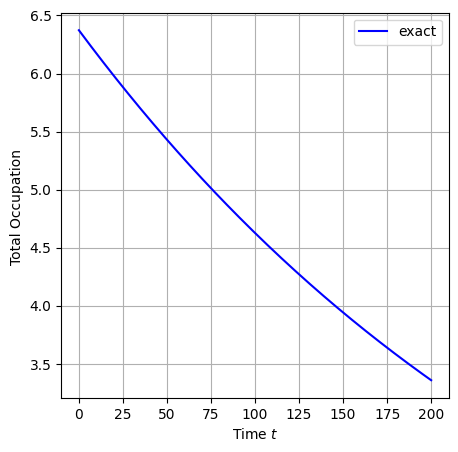

In [1203]:
import matplotlib.pyplot as plt

fig1, axs1 = plt.subplots(1, 1, sharex=True, figsize=(5, 5))

colors = ['b', 'g', 'r', 'c', 'm', 'y']

# Plot imaginary parts
axs1.plot(total_number, label="exact", color=colors[0])
#axs1.plot( tdvp_ex1.operator_results()[0] , label="tdvp", color=colors[1], linestyle='--')
#axs1.plot( np.real(tdvp_ex1.operator_results()[0]) + np.imag(tdvp_ex1.operator_results()[0]) , label="tdvp", color=colors[1], linestyle='--')




# axs1.plot(results_N_ttn, label="N_ttn")
# axs1.plot(results_N_t3n, label="N_t3n")

axs1.set_xlabel("Time $t$")
axs1.set_ylabel("Total Occupation ")
axs1.grid(True)
axs1.legend()

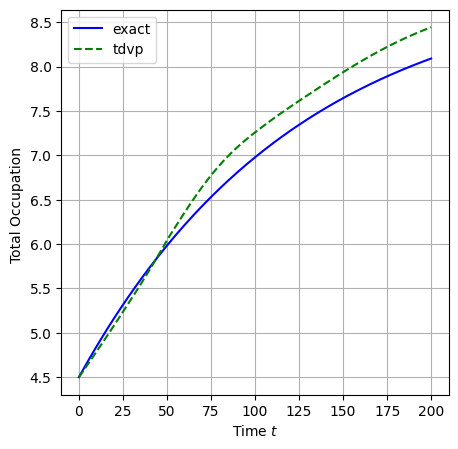

In [438]:
import matplotlib.pyplot as plt

fig1, axs1 = plt.subplots(1, 1, sharex=True, figsize=(5, 5))

colors = ['b', 'g', 'r', 'c', 'm', 'y']

# Plot imaginary parts
axs1.plot(total_number, label="exact", color=colors[0])
axs1.plot( tdvp_ex1.operator_results()[0] , label="tdvp", color=colors[1], linestyle='--')
#axs1.plot( np.real(tdvp_ex1.operator_results()[0]) + np.imag(tdvp_ex1.operator_results()[0]) , label="tdvp", color=colors[1], linestyle='--')




# axs1.plot(results_N_ttn, label="N_ttn")
# axs1.plot(results_N_t3n, label="N_t3n")

axs1.set_xlabel("Time $t$")
axs1.set_ylabel("Total Occupation ")
axs1.grid(True)
axs1.legend()

In [ ]:
tdvp_ex2.run_ex_t3n(evaluation_time=2)

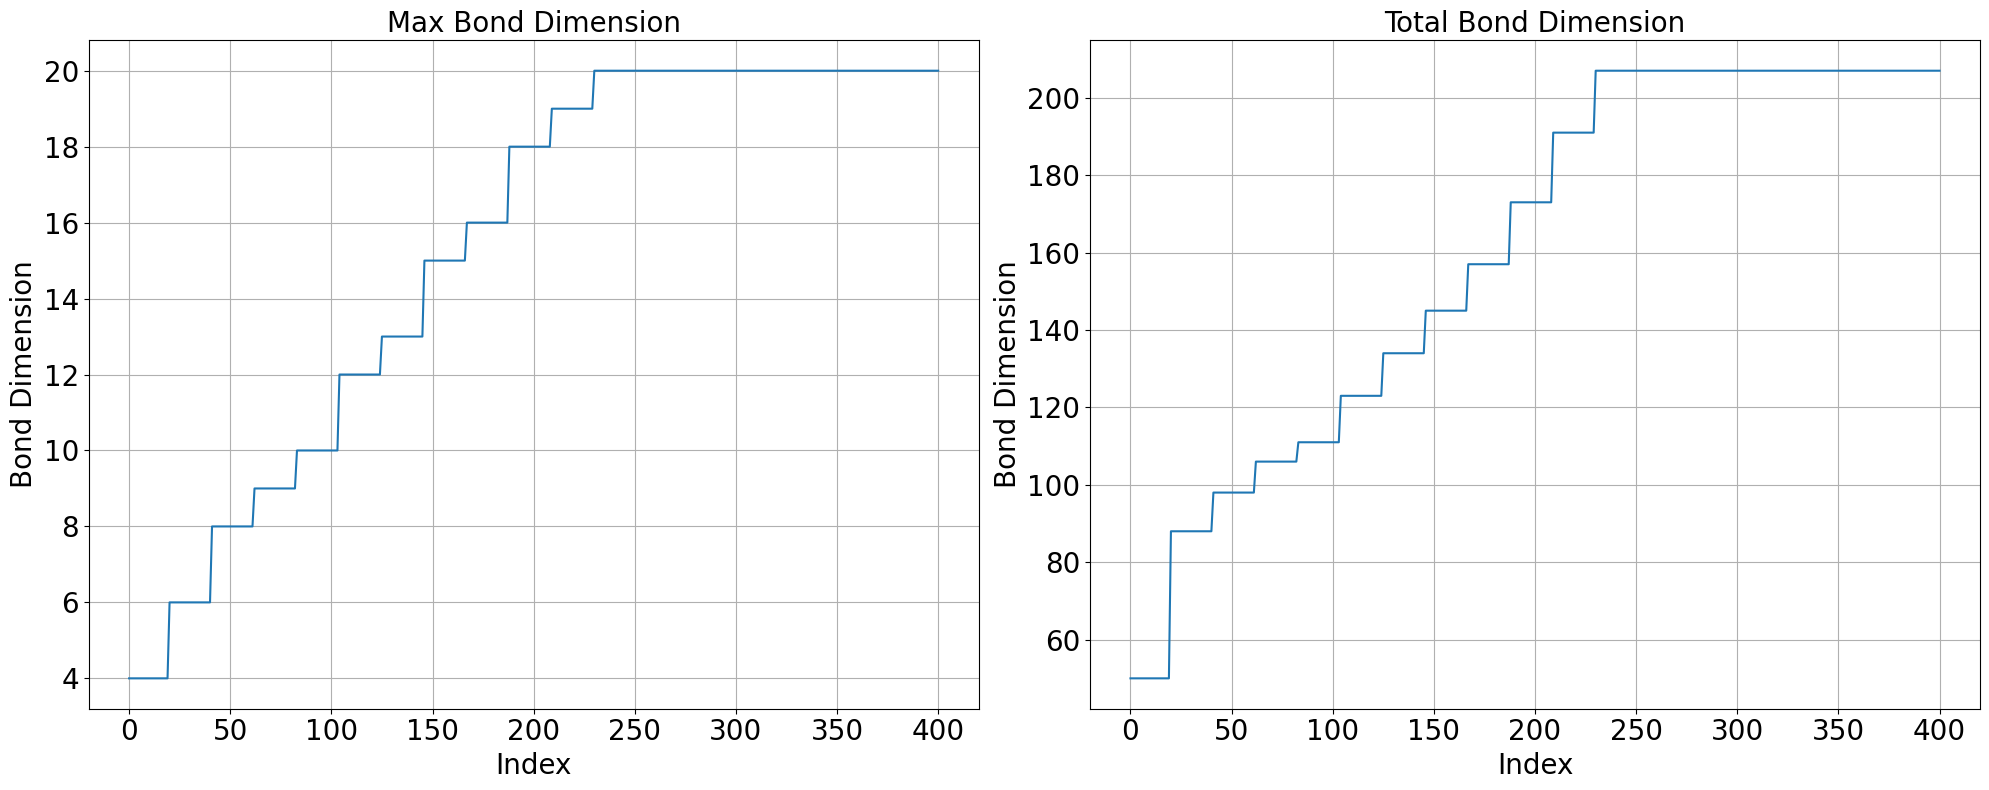

In [36]:
import matplotlib.pyplot as plt


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Plot max bond dimension
ax1.plot(tdvp_ex2.max_bond_dim)
ax1.set_title('Max Bond Dimension', fontsize=20)
ax1.set_xlabel('Index', fontsize=20)
ax1.set_ylabel('Bond Dimension', fontsize=20)
ax1.tick_params(axis='both', which='major', labelsize=20)

ax1.grid(True)

# Plot total bond dimension
ax2.plot(tdvp_ex2.total_bond_dim)
ax2.set_title('Total Bond Dimension', fontsize=20)
ax2.set_xlabel('Index', fontsize=20)
ax2.set_ylabel('Bond Dimension', fontsize=20)
ax2.tick_params(axis='both', which='major', labelsize=20)
ax2.grid(True)


# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


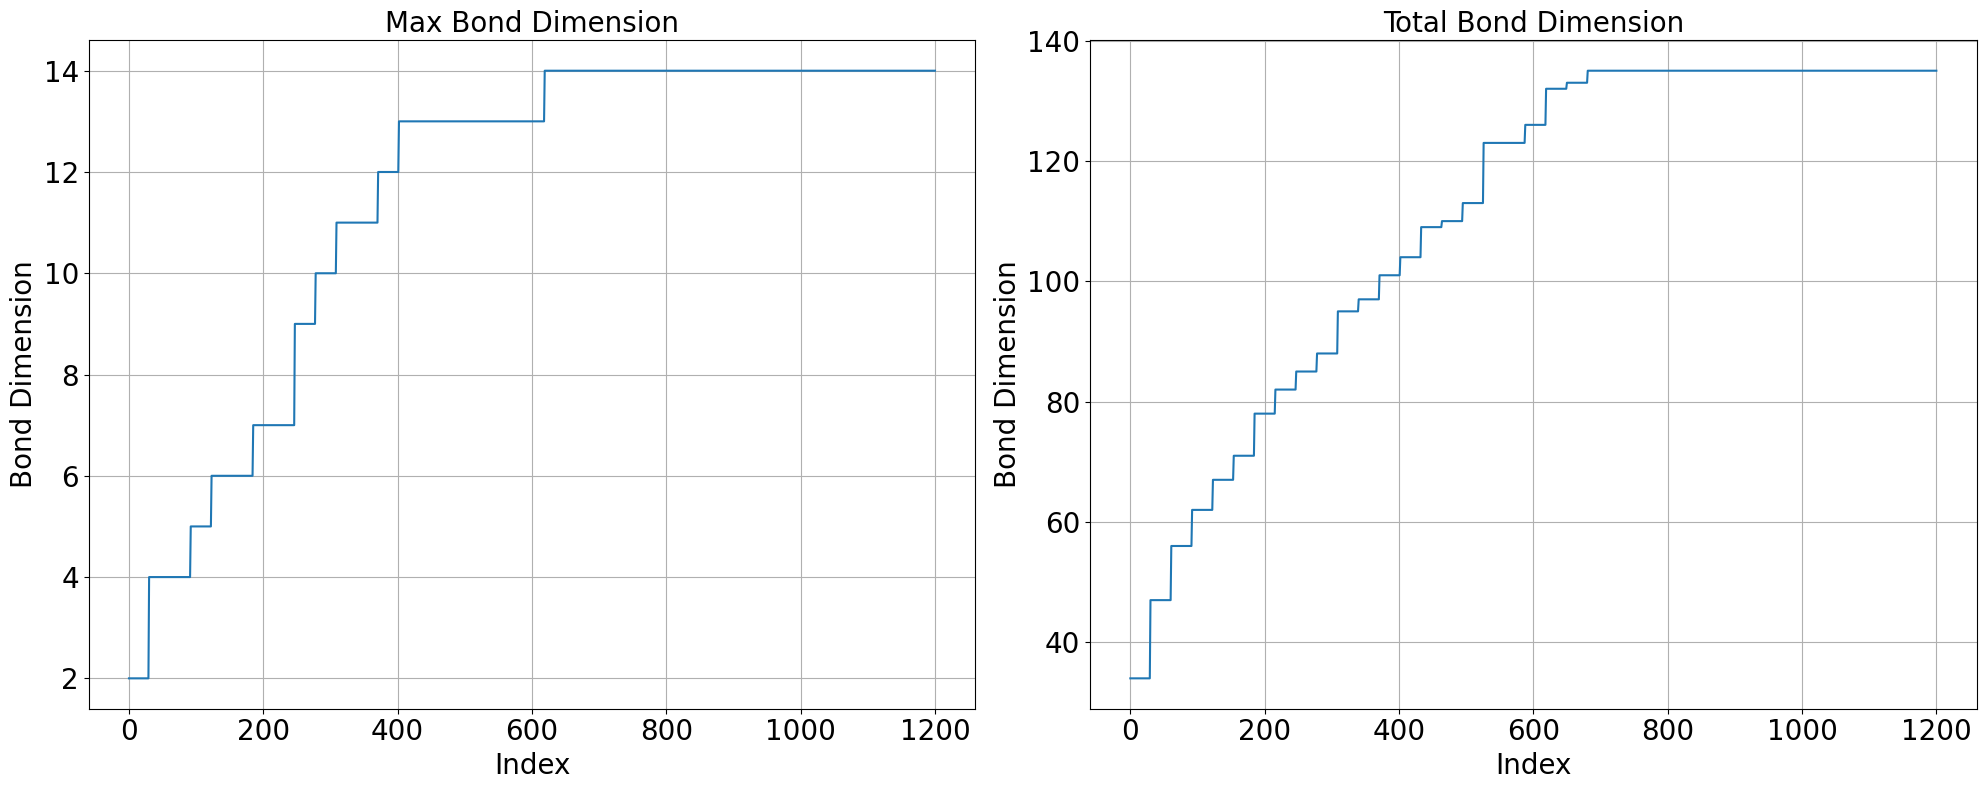

In [431]:
import matplotlib.pyplot as plt


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Plot max bond dimension
ax1.plot(tdvp_ex1.max_bond_dim)
ax1.set_title('Max Bond Dimension', fontsize=20)
ax1.set_xlabel('Index', fontsize=20)
ax1.set_ylabel('Bond Dimension', fontsize=20)
ax1.tick_params(axis='both', which='major', labelsize=20)

ax1.grid(True)

# Plot total bond dimension
ax2.plot(tdvp_ex1.total_bond_dim)
ax2.set_title('Total Bond Dimension', fontsize=20)
ax2.set_xlabel('Index', fontsize=20)
ax2.set_ylabel('Bond Dimension', fontsize=20)
ax2.tick_params(axis='both', which='major', labelsize=20)
ax2.grid(True)


# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


In [24]:
X , Y , Z = ptn.pauli_matrices()
Z @ Z == Z.T @ Z.T

array([[ True,  True],
       [ True,  True]])

C:\Users\edpou\AppData\Local\Temp\ipykernel_12552\2303996310.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('tab20')  # Choose a colormap with more distinct colors


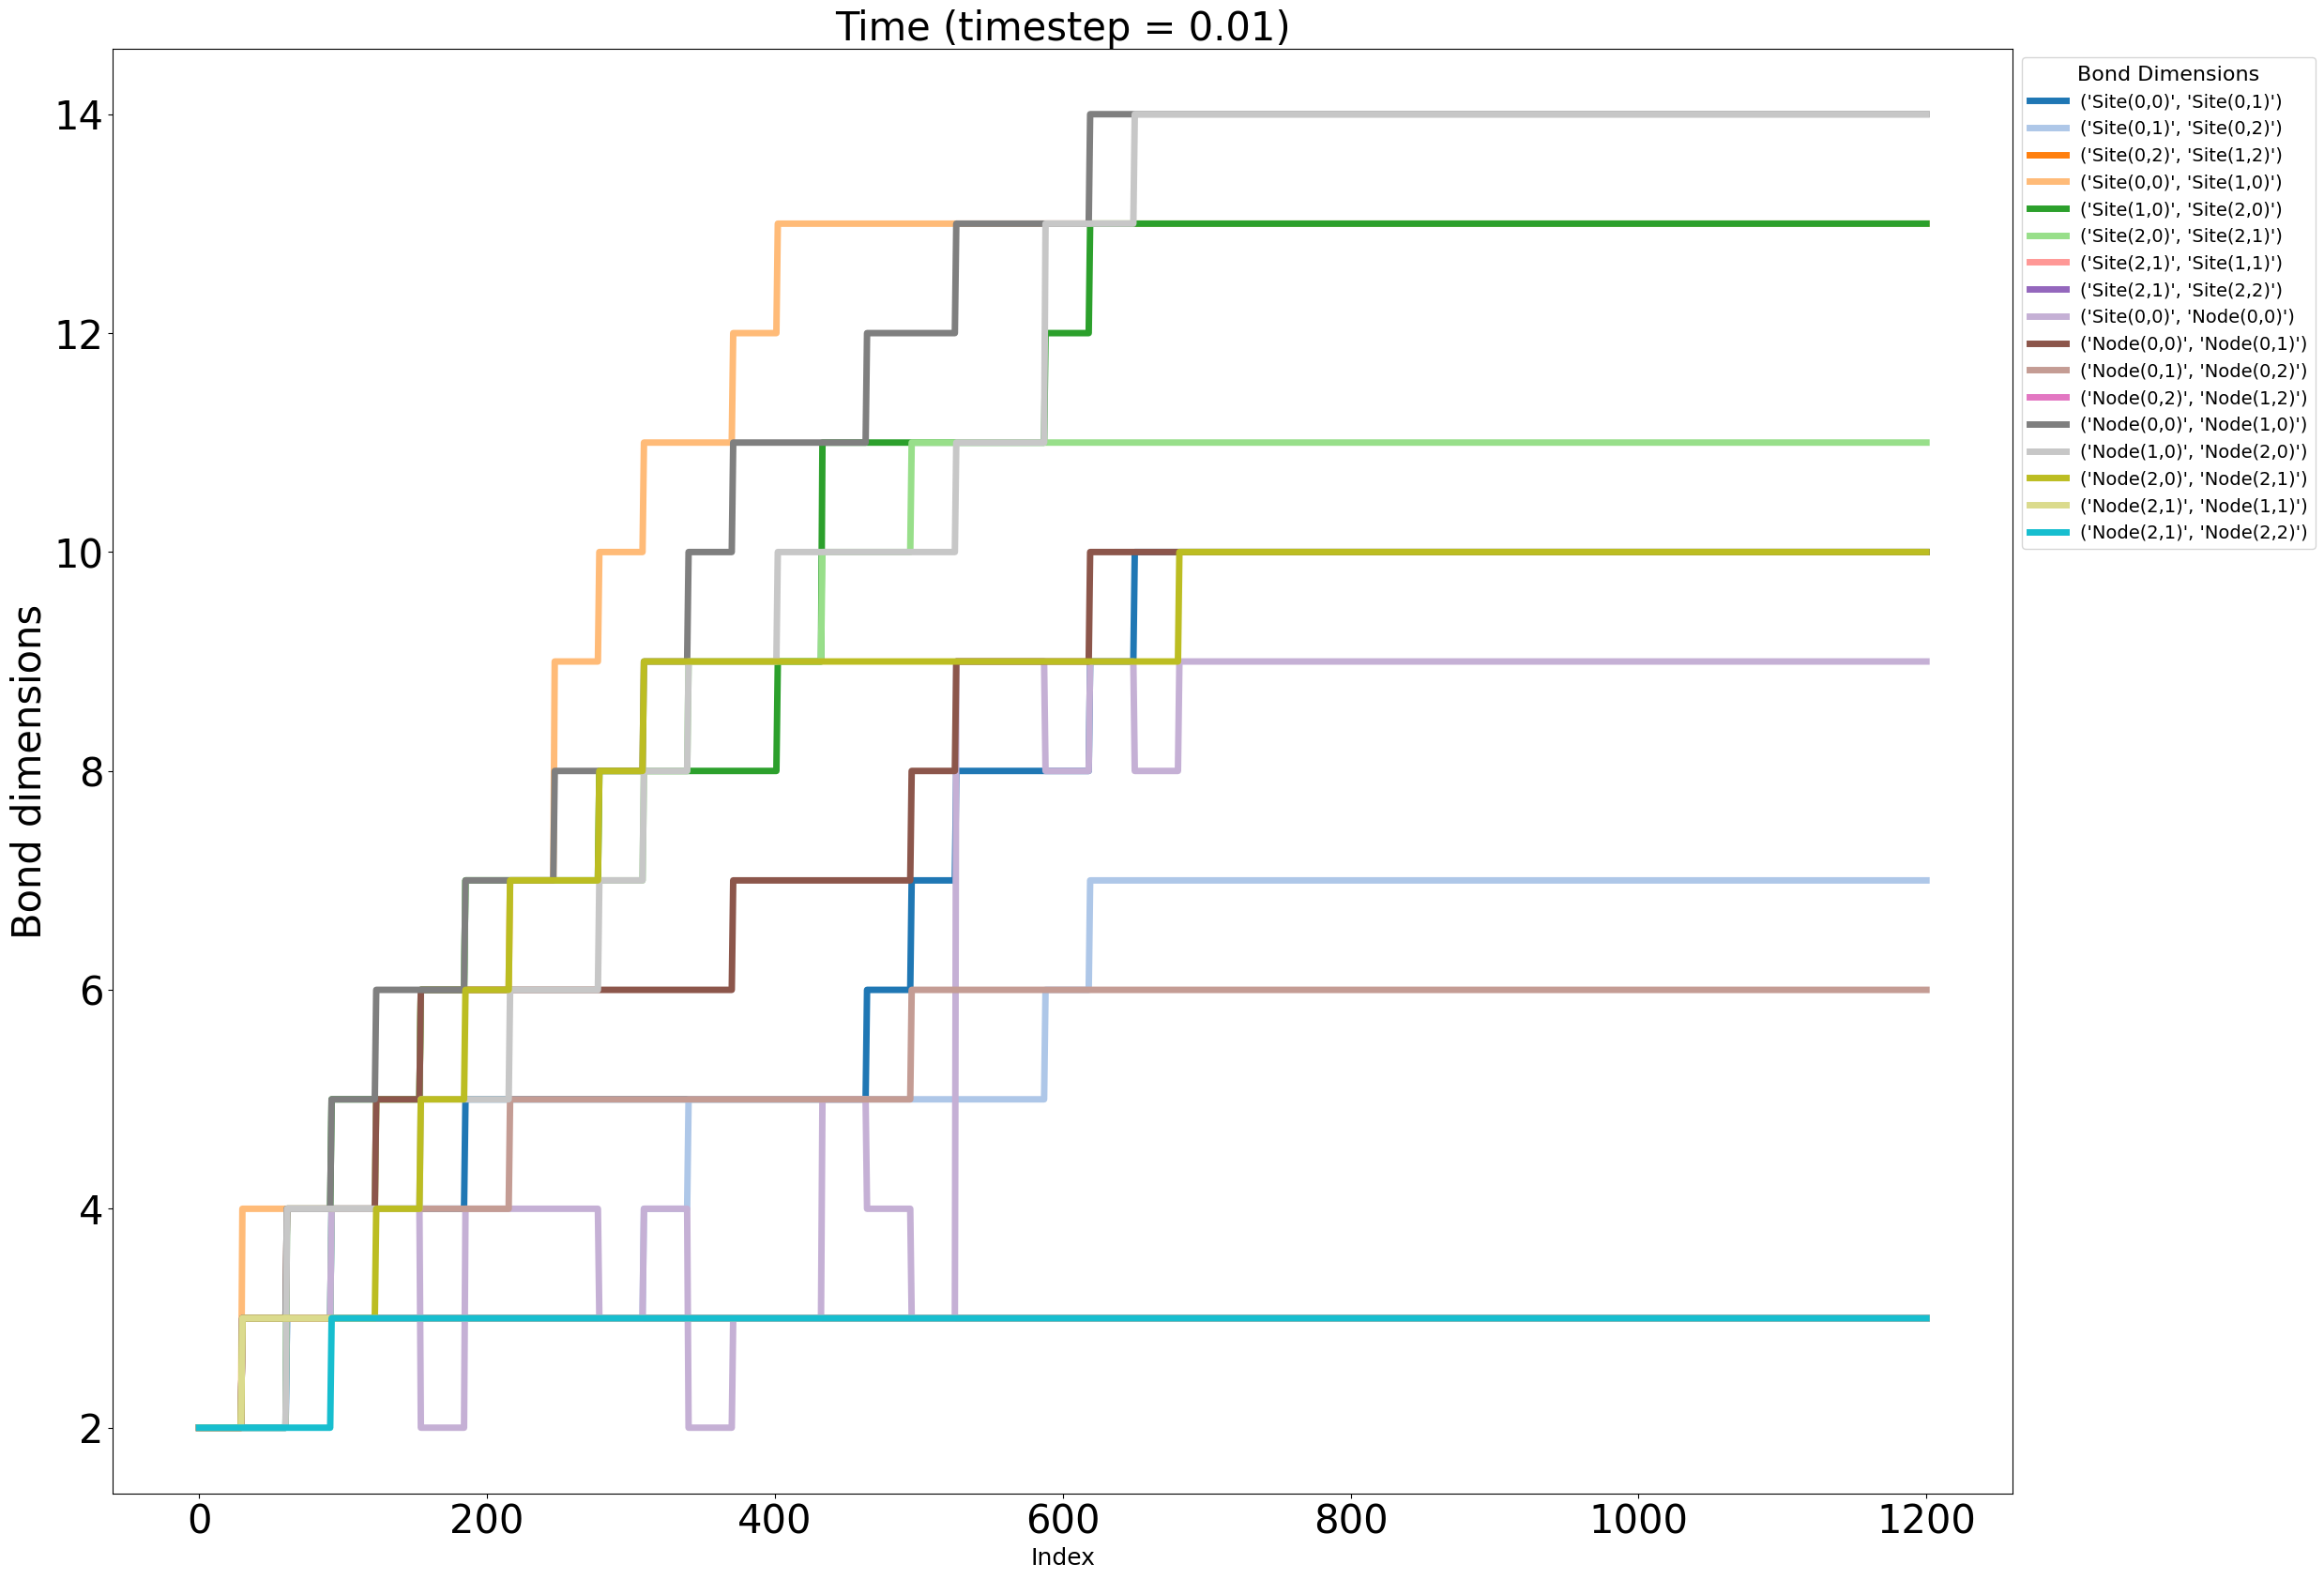

In [432]:
import matplotlib.pyplot as plt

def get_distinct_colors(n):
    """Generates a list of n distinct, visually appealing colors using colormap cyclically."""
    from matplotlib.cm import get_cmap
    cmap = get_cmap('tab20')  # Choose a colormap with more distinct colors
    return [cmap(i / n) for i in range(n)]

fig, ax = plt.subplots(figsize=(30, 20))

# Get distinct colors
colors = get_distinct_colors(len(tdvp_ex1.bond_dims))

# Plot each bond dimension with its corresponding color
for i, (key, values) in enumerate(tdvp_ex1.bond_dims.items()):
    x = list(range(len(values)))
    ax.plot(x, values, label=key, color=colors[i], linewidth=5)  # Increased linewidth for better visibility

# Customize the legend for better readability
legend = ax.legend(title='Bond Dimensions', loc='upper left', bbox_to_anchor=(1, 1), fontsize=14, title_fontsize=16)

# Customize plot labels and title
ax.set_xlabel('Index', fontsize=18)
ax.set_ylabel('Bond dimensions', fontsize=30)
ax.set_title('Time (timestep = 0.01)', fontsize=30)

# Change font size for tick labels on x and y axes
ax.tick_params(axis='both', which='major', labelsize=30)

# Increase the space for the legend
plt.subplots_adjust(right=0.8)  # Adjusts the right margin to fit the large legend

plt.show()

In [ ]:
# 3 >> 4 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

# Define the binary tree structure and data
data = {
  (1, 2): [1, 2, 3, 4],
  (1, 3): [1, 3, 5, 7],
  (2, 4): [1, 1, 2, 2],
  (2, 5): [1, 2, 2, 3],
  (3, 6): [1, 2, 3, 3],
  (3, 7): [1, 1, 2, 4]
}

# Set up the visualization
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Define node positions
positions = {
  1: (0, 0, 0),
  2: (-1, -1, 0),
  3: (1, -1, 0),
  4: (-1.5, -2, 0),
  5: (-0.5, -2, 0),
  6: (0.5, -2, 0),
  7: (1.5, -2, 0)
}

# Draw edges and nodes
for edge in data:
  x = [positions[edge[0]][0], positions[edge[1]][0]]
  y = [positions[edge[0]][1], positions[edge[1]][1]]
  z = [positions[edge[0]][2], positions[edge[1]][2]]
  ax.plot(x, y, z, c='gray', linewidth=1)

for node, pos in positions.items():
  ax.scatter(*pos, c='r', s=100)
  ax.text(*pos, f'Node {node}', fontsize=10, ha='center', va='bottom')

# Define colors for the bars
colors = ['#FFB74D', '#FFEB3B', '#4CAF50', '#80DEEA', '#EF5350']

# Scale factor to adjust the height of the charts
scale_factor = 0.3

# Add 3D bar charts along the edges
for edge, strengths in data.items():
  start_pos = np.array(positions[edge[0]])
  end_pos = np.array(positions[edge[1]])
  n = len(strengths)

  # Generate positions along the edge
  x_positions = np.linspace(start_pos[0], end_pos[0], n)
  y_positions = np.linspace(start_pos[1], end_pos[1], n)

  for i, strength in enumerate(strengths):
      x = x_positions[i]
      y = y_positions[i]
      z = 0  # Start from the base
      dx = dy = 0.1  # Width of the bar
      dz = strength * scale_factor  # Height of the bar
      ax.bar3d(x, y, z, dx, dy, dz, color=colors[i], alpha=0.8)

# Set labels and title
ax.set_xlabel('X', labelpad=10)
ax.set_ylabel('Y', labelpad=10)
ax.set_zlabel('Bond Strength', labelpad=10)
ax.set_title('Binary Tree with Rectangular Area Charts', pad=20)

# Adjust the view
ax.view_init(elev=20, azim=45)

# Set axis limits to ensure all data is visible
ax.set_xlim(-2, 2)
ax.set_ylim(-3, 1)
ax.set_zlim(0, max(max(strengths) for strengths in data.values()) * scale_factor)

# Add a color bar
from matplotlib.cm import ScalarMappable
from matplotlib.colors import ListedColormap, BoundaryNorm

cmap = ListedColormap(colors)
bounds = [1, 2, 3, 4, 5]
norm = BoundaryNorm(bounds, cmap.N)
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', pad=0.1)
cbar.set_ticks([1.5, 2.5, 3.5, 4.5])
cbar.set_ticklabels(['1', '2', '3', '4'])
cbar.set_label('Bond Strength (Scaled)', fontsize=12)

plt.tight_layout()
plt.show()

In [58]:
print( ttn.total_bond_dim())
print( ttn_ex.total_bond_dim())


30
170
